### Importing Libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os

import seaborn as sns

%run helpFunction.ipynb

2024-05-26 01:45:12.339890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 01:45:12.399932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 01:45:13.334383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
DeiT & 81% & 81% & 82% & 81.000000 \\
Vision Transformer Lite & 79% & 79% & 79% & 79.000000 \\
VisionTransformer & 73% & 72% & 72% & 72.000000 \\
Basic CNN & 62% & 67% & 61% & 58.000000 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3166413/671559329.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Konfiguration Settings

In [3]:
image_size = (250, 250)
batch_size = 32

### Data Preprocessing

In [4]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [5]:
#Canny edge detection
def apply_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    tight = cv2.Canny(blurred, 140, 160)
    tight = cv2.resize(tight, image_size)
    tight = np.expand_dims(tight, axis=-1)
    
    return tight

In [6]:
#Morphology Methode wurde angwendet
def apply_morphology(image, target_size=(250, 250)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 190, 210, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    image = cv2.resize(eroded, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [7]:
def black_and_white(image, target_size=(250, 250)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [8]:
def load_images_from_folder(folder, label, target_size, type='normal'):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:             
            img = cv2.imread(img_path)
            if type == 'canny':
                img = apply_canny(img)
            elif type == 'morphology':
                img = apply_morphology(img, target_size)
            elif type == 'normal':
                img = black_and_white(img, target_size)
            else:    
                raise ValueError(f"Unbekannter Typ '{type}'")
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [9]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(path_with_sign, 0, image_size, type='canny')
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(path_without_sign, 1, image_size, type='canny')

images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(path_with_sign, 0, image_size, type='morphology')
images_without_sign_morphology, labels_without_sign_morphology = load_images_from_folder(path_without_sign, 1, image_size, type='morphology')

images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(path_with_sign, 0, image_size, type='normal')
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(path_without_sign, 1, image_size, type='normal')


images_with_sign_canny = np.array(images_with_sign_canny)
images_without_sign_canny = np.array(images_without_sign_canny)
images_with_sign_morphology = np.array(images_with_sign_morphology)
images_without_sign_morphology = np.array(images_without_sign_morphology)
images_with_sign_normal = np.array(images_with_sign_normal)
images_without_sign_normal = np.array(images_without_sign_normal)

images_with_sign = np.concatenate((images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal), axis=-1)
images_without_sign = np.concatenate((images_without_sign_canny, images_without_sign_morphology, images_without_sign_normal), axis=-1)
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

print("Shape of all_images tensor:", all_images.shape)
print("Shape of all_labels tensor:", all_labels.shape)

Shape of all_images tensor: (1456, 250, 250, 3)
Shape of all_labels tensor: (1456,)


### Data Normalization

In [10]:
all_images = all_images.astype('float32') / 255.0
all_images.shape

(1456, 250, 250, 3)

In [11]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(namelabels[label])
    plt.show()

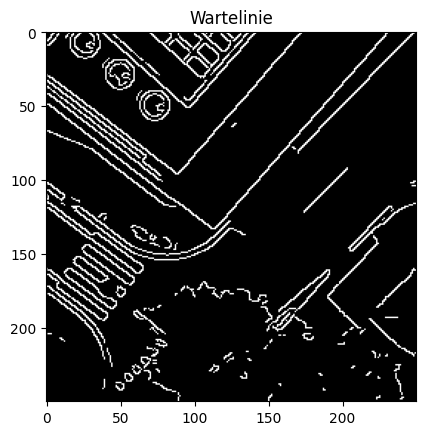

In [12]:
show_image(images_with_sign_canny[4], labels_with_sign_canny[4])

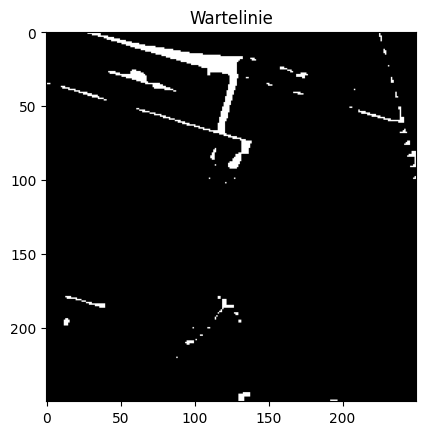

In [13]:
show_image(images_with_sign_morphology[3], labels_with_sign_morphology[3])

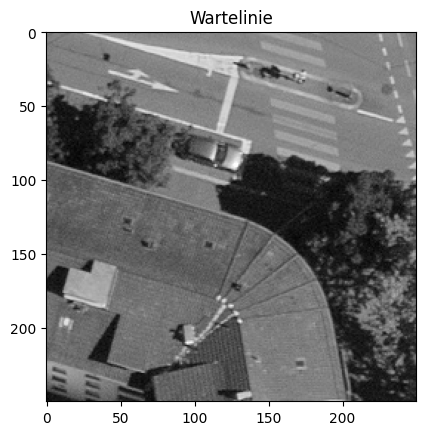

In [14]:
show_image(images_with_sign_normal[3], labels_with_sign_normal[3])

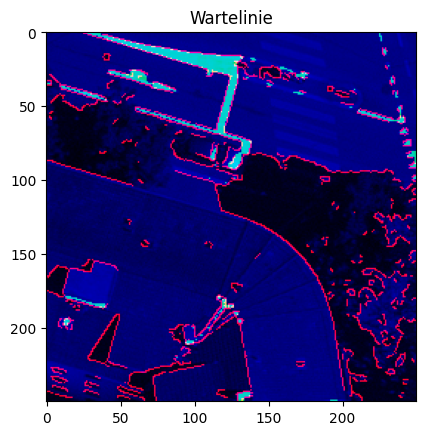

In [15]:
show_image(all_images[3], all_labels[3])

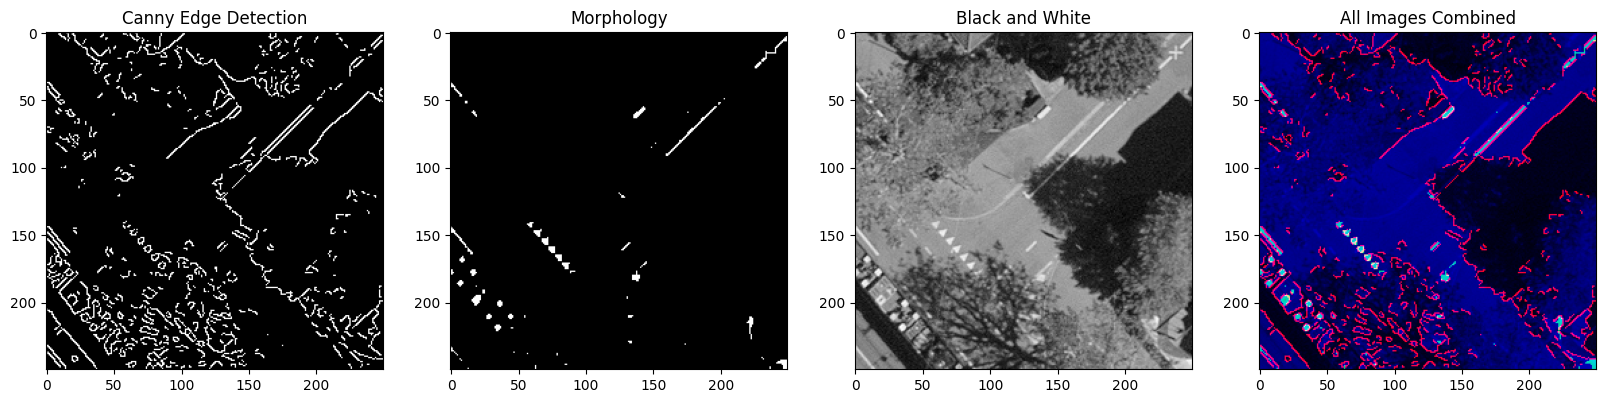

In [16]:

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(images_with_sign_canny[1], cmap='gray')
ax[0].set_title('Canny Edge Detection')

ax[1].imshow(images_with_sign_morphology[1], cmap='gray')
ax[1].set_title('Morphology')

ax[2].imshow(images_with_sign_normal[1], cmap='gray')
ax[2].set_title('Black and White')

ax[3].imshow(all_images[1], cmap='gray')
ax[3].set_title('All Images Combined')

plt.show()

### Data Splitting

In [17]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [18]:
train_images.shape, test_images.shape

((1164, 250, 250, 3), (292, 250, 250, 3))

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [20]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

### Vortrainiertes Modell

In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None)
base_model.trainable = False

2024-05-26 01:45:25.250981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72859 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x) 

In [23]:
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.10
)

Epoch 1/20


I0000 00:00:1716680733.226418 3166800 service.cc:145] XLA service 0x7fbc04059400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716680733.226490 3166800 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-26 01:45:33.442413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 01:45:34.747124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1716680736.856739 3166962 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8504', 4892 bytes spill stores, 5688 bytes spill loads



 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4688 - loss: 4.1060

I0000 00:00:1716680742.480181 3166800 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5413 - loss: 4.0523

I0000 00:00:1716680746.553908 3167163 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8504', 244 bytes spill stores, 244 bytes spill loads



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5450 - loss: 4.0483

I0000 00:00:1716680758.538998 3167453 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2465', 244 bytes spill stores, 244 bytes spill loads



33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 640ms/step - accuracy: 0.5468 - loss: 4.0464 - val_accuracy: 0.4872 - val_loss: 4.0443
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7417 - loss: 3.7297 - val_accuracy: 0.5299 - val_loss: 3.9402
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7881 - loss: 3.6153 - val_accuracy: 0.7009 - val_loss: 3.7019
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8102 - loss: 3.5136 - val_accuracy: 0.7607 - val_loss: 3.6110
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7727 - loss: 3.4893 - val_accuracy: 0.8034 - val_loss: 3.4658
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8266 - loss: 3.3726 - val_accuracy: 0.8120 - val_loss: 3.4311
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8561 - loss: 3.2935 - val_accuracy: 0.8291 - val_loss: 3.3616
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8543 - loss: 3.2428 - val_accuracy: 0.8034 - val_loss: 

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 590ms/step - accuracy: 0.8323 - loss: 2.7451
Testgenauigkeit: 0.8185, Testverlust: 2.7368


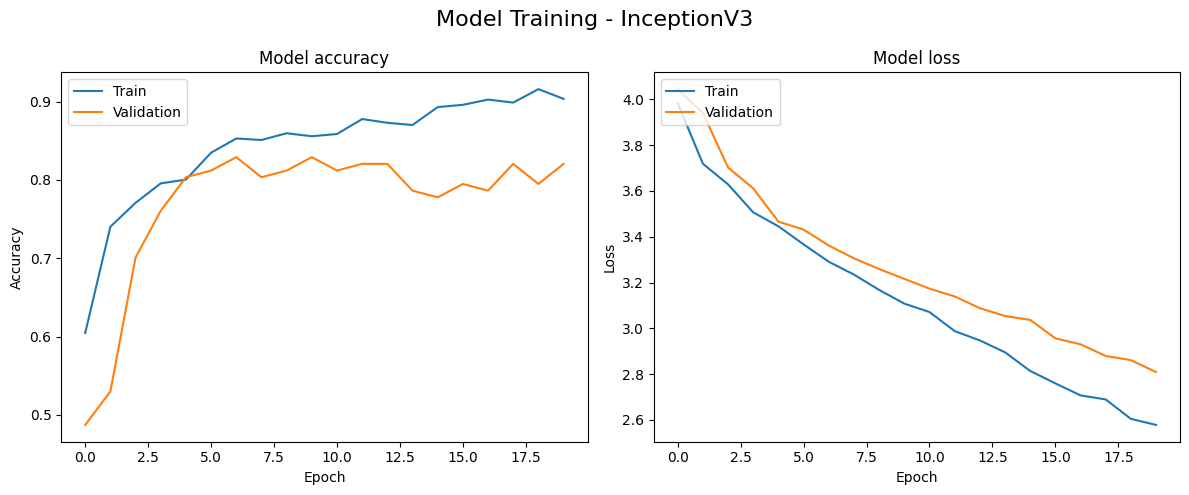

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Model Training - InceptionV3', fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'InceptionV3')

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step
              precision    recall  f1-score     support
0              0.891667  0.727891  0.801498  147.000000
1              0.767442  0.910345  0.832808  145.000000
accuracy       0.818493  0.818493  0.818493    0.818493
macro avg      0.829554  0.819118  0.817153  292.000000
weighted avg   0.829980  0.818493  0.817046  292.000000
81.84931506849315
        Modell Accuracy Precision Recall F1-Score                       Date
0  InceptionV3      82%       83%    82%      82% 2024-05-26 01:46:32.313357


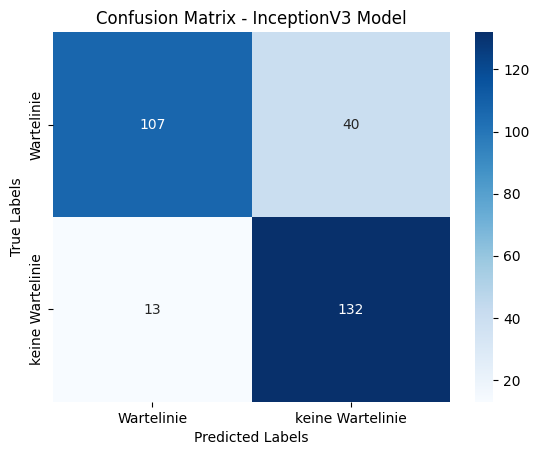

In [29]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3 Model')
plt.show()

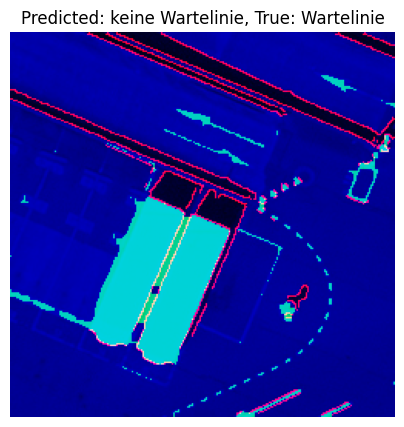

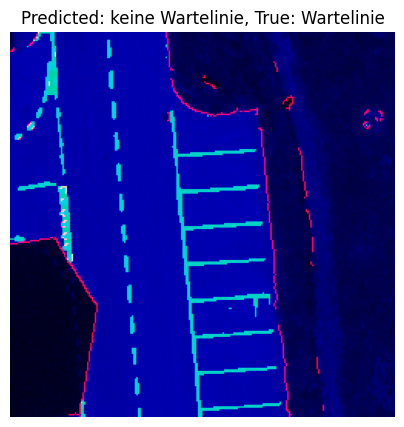

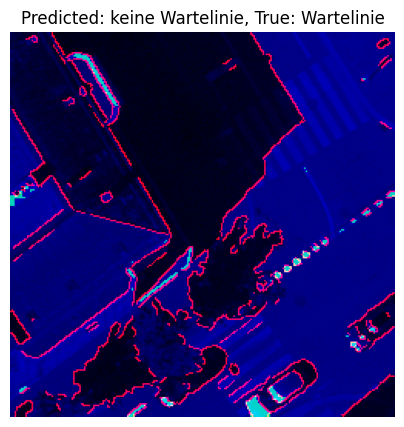

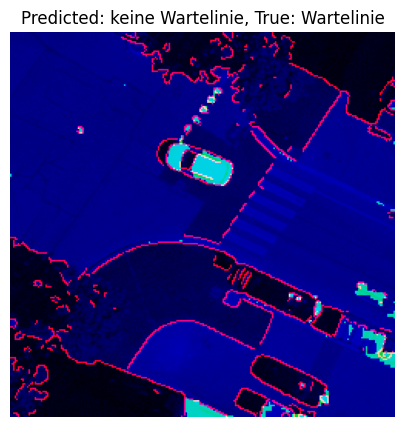

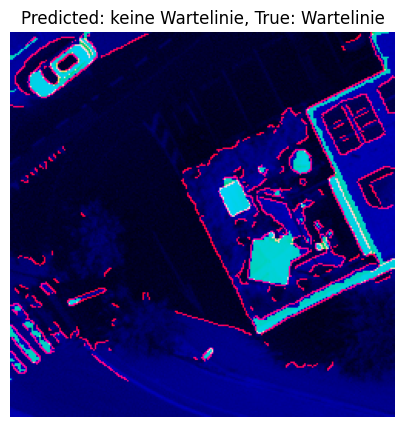

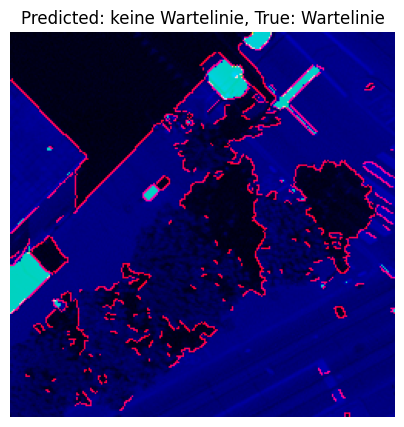

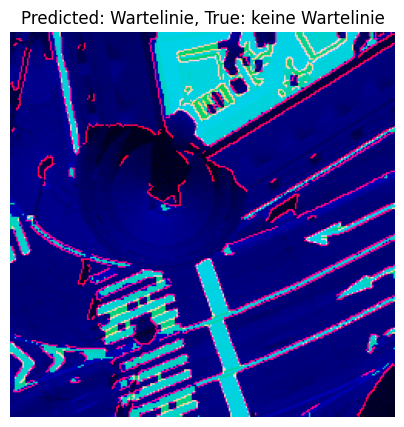

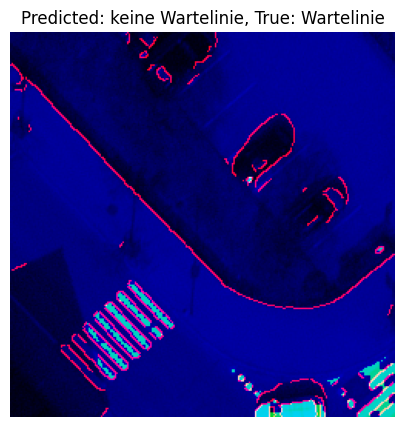

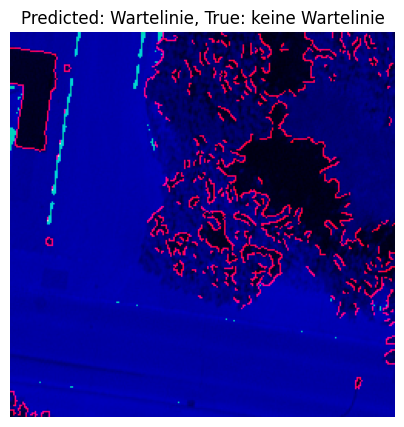

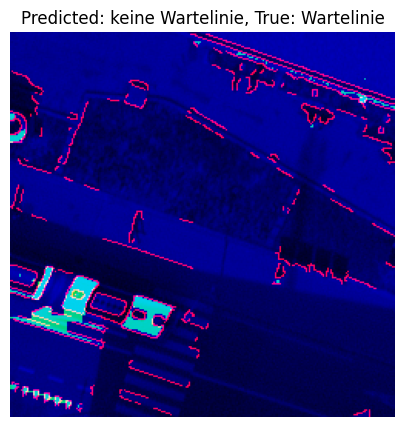

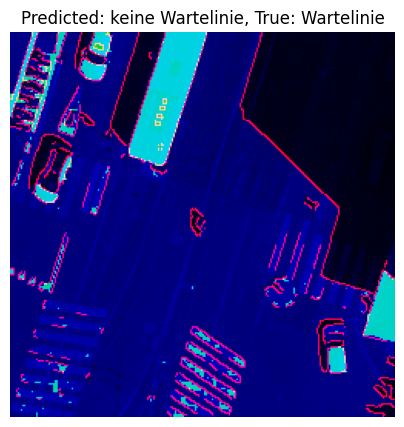

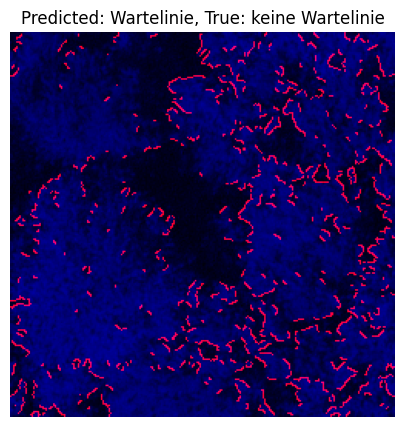

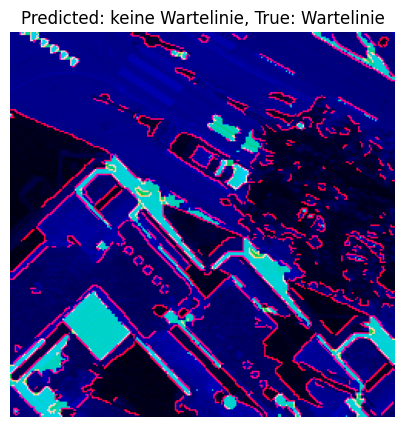

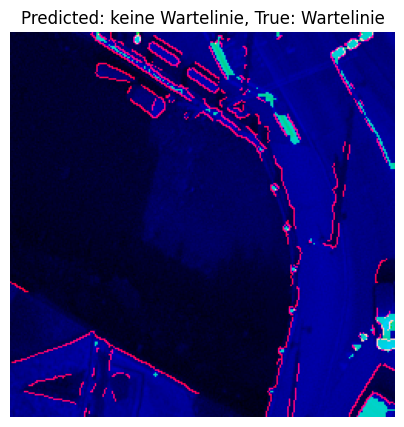

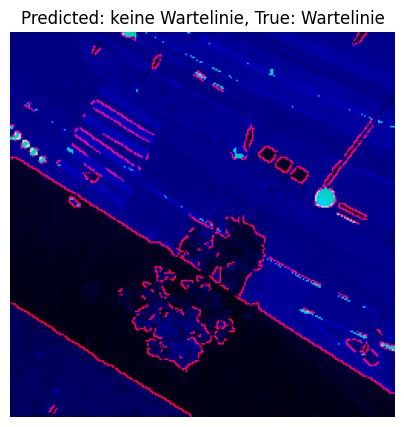

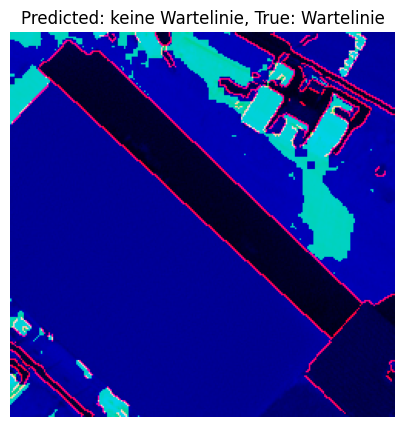

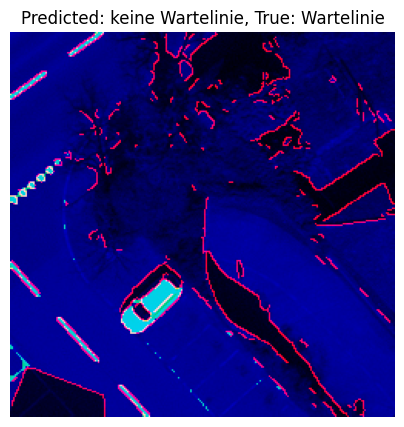

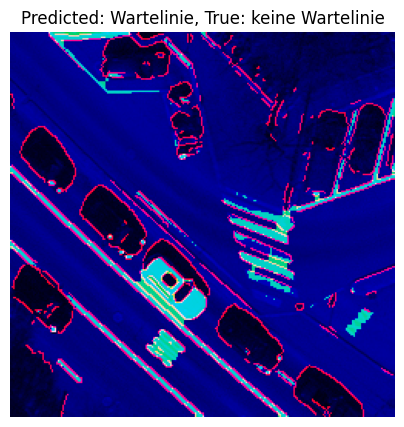

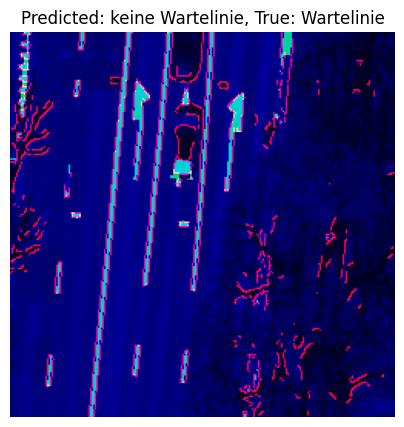

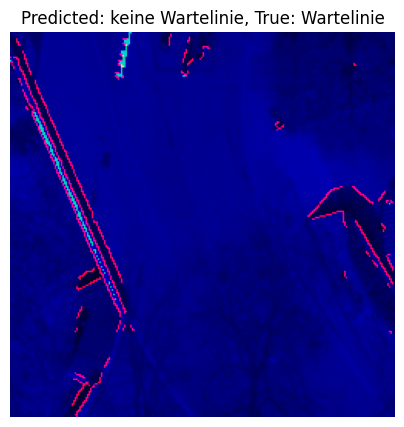

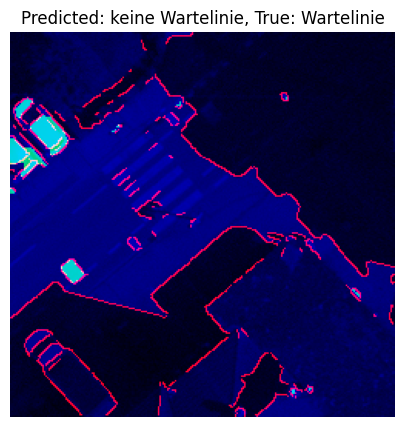

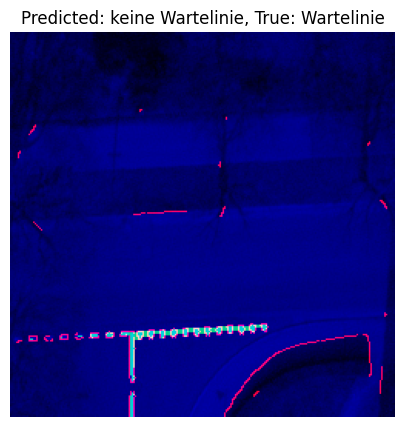

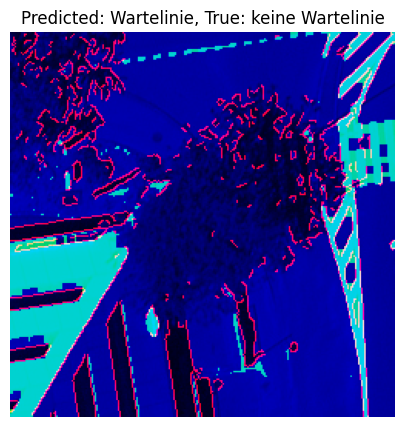

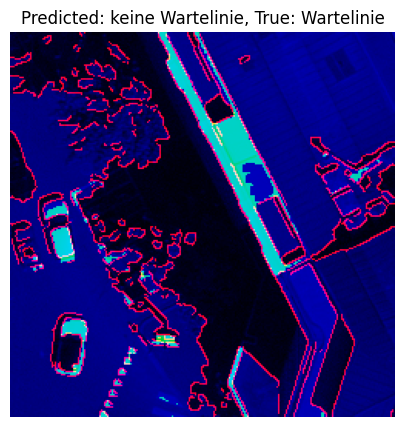

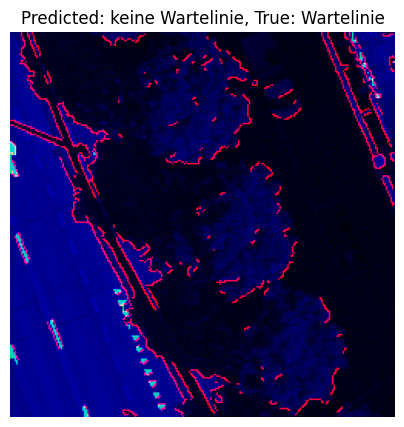

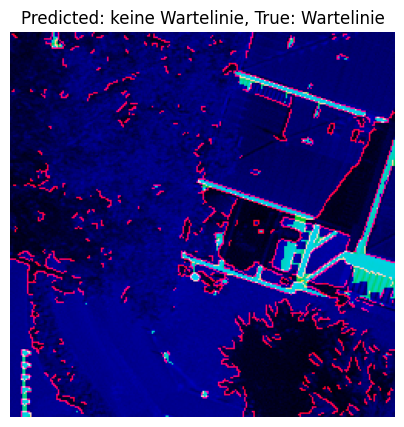

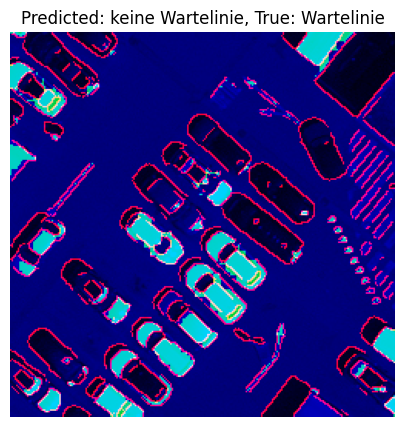

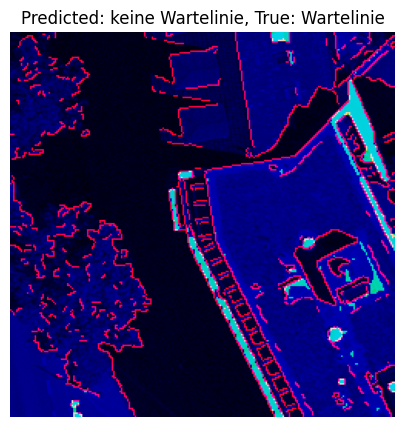

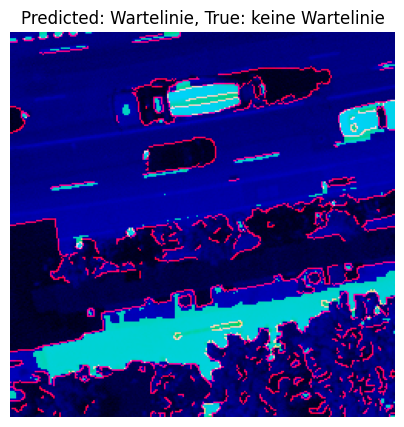

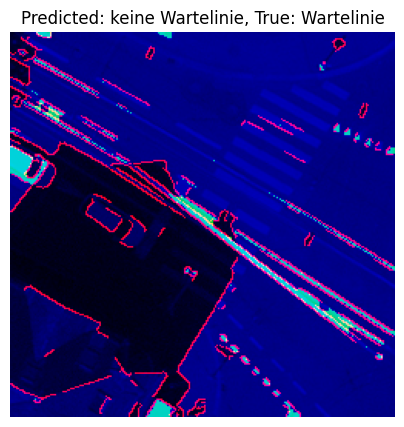

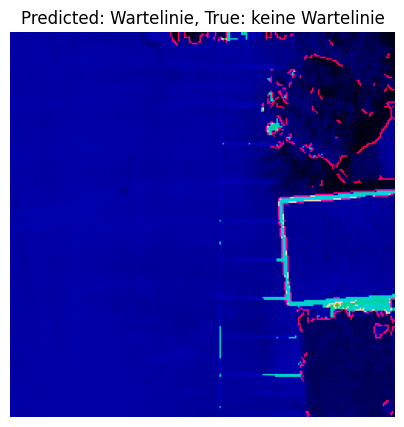

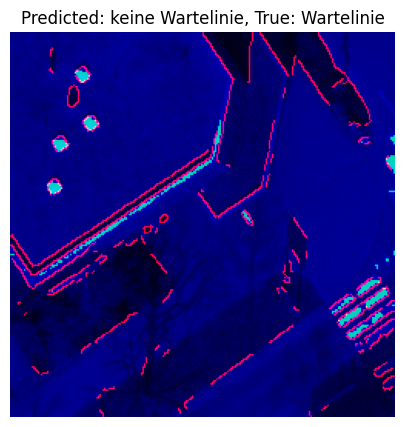

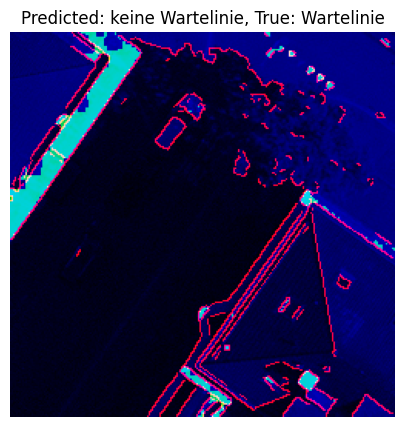

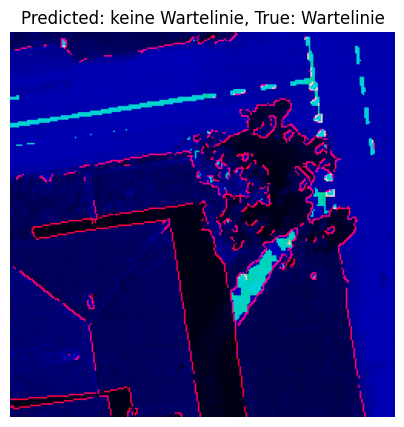

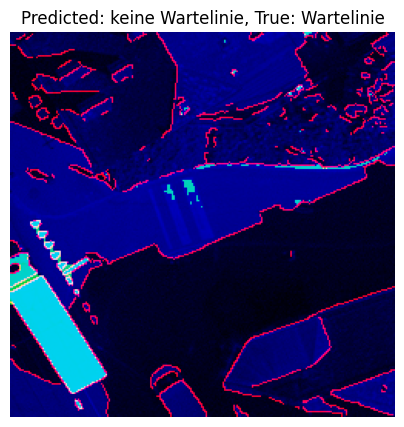

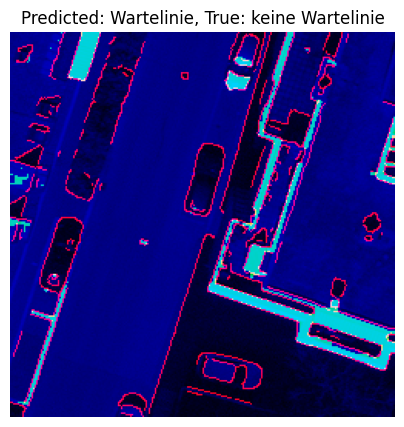

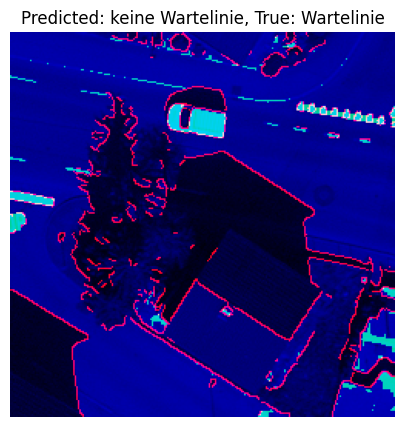

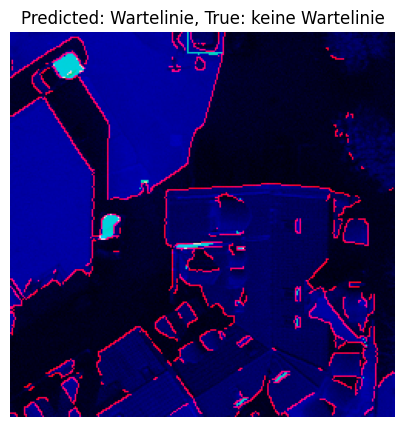

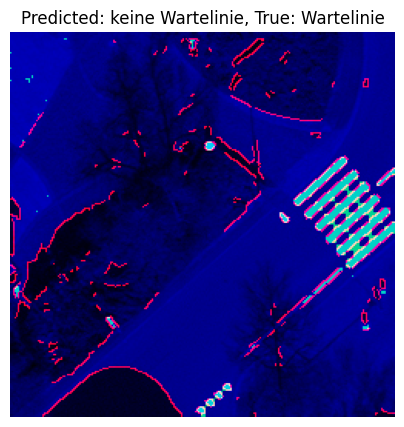

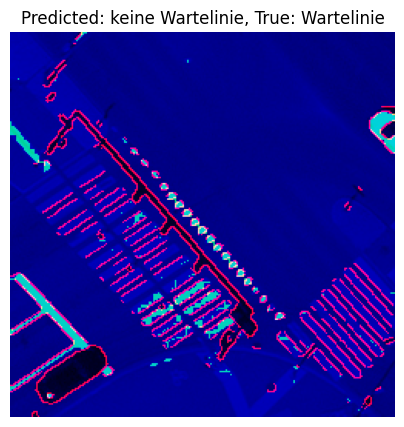

In [30]:
predictions_class_indices = (predictions.flatten() > 0.5).astype(int)

test_labels_class_indices = test_labels.flatten().astype(int)

incorrect_indices = [i for i, (true, pred) in enumerate(zip(test_labels_class_indices, predictions_class_indices)) if true != pred]

max_images_to_show = 40
shown_images = 0

for i in incorrect_indices:
    if shown_images < max_images_to_show:
        plt.figure(figsize=(5,5))
        plt.imshow(test_images[i], cmap='gray' if test_images[i].ndim == 2 else None)

        predicted_label = namelabels.get(predictions_class_indices[i], "Unknown")
        true_label = namelabels.get(test_labels_class_indices[i], "Unknown")
        plt.title(f'Predicted: {predicted_label}, True: {true_label}')
        plt.axis('off')
        plt.show()
        shown_images += 1
    else:
        break